# Deconvolution demo.
SPIE Short course on Machine Learning for Image Restoration.  
Author: Jesse Wilson (jesse.wilson@colostate.edu).

Walk through training and evaluation of a convolutional network for denoising. This code is provided for educational purposes.


# Preliminaries

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # bug workaround needed on my laptop--not sure why

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision.transforms.functional import gaussian_blur
import numpy as np
from random import randint
from torch import fft

# get available GPU 
# supports NVIDIA (CUDA), Intel (XPU), and Apple (MPS)
# (CAUTION: AI-generated code -- NOT validated on all systems!)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif hasattr(torch,"xpu") and torch.xpu.is_available():
    device = torch.device("xpu:0")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Selected device: {device}.")

In [ ]:
# load a dataset

batch_size=64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((18,18,18,18))])
dataset_train = datasets.MNIST(root='data',train=True,download=True,transform=transform)
dataset_val = datasets.MNIST(root='data',train=False,download=True,transform=transform)

dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size, shuffle=False)

img = next(iter(dataloader_train))[0][1].squeeze()
plt.imshow(img)
plt.colorbar()
plt.show()

# Set up a class to simulate the optical system
Assumes spatially-invariant PSF resulting from a 4f system. Incoherent imaging. For more information, see [Voelz _Computational Fourier Optics: A MATLAB Tutorial_](https://www.spiedigitallibrary.org/ebooks/TT/Computational-Fourier-Optics-A-MATLAB-Tutorial/eISBN-9780819482051/10.1117/3.858456).

In [ ]:
# define a (incoherent) PSF
class ForwardModel( nn.Module ):
    def __init__(self, pupil_width=0.5, ny=64, nx=64):
        super().__init__()

        # set up sampling grid
        dx = 2 / nx
        x = torch.linspace(-1,1-dx,nx)
        y = x
        X,Y = torch.meshgrid(x,y)
        R=torch.sqrt(X**2+Y**2)
        CTF = R < torch.Tensor([pupil_width])

        # set up OTF
        CSF = fft.fftshift(fft.ifft2(fft.ifftshift(CTF)))
        PSF = CSF.abs()**2
        OTF = fft.fftshift(fft.fft2(fft.ifftshift(PSF)))
        OTF = OTF / torch.max(OTF.abs())
        self.OTF = OTF

    def forward(self, x):
        # convolve image with PSF by product with OTF in Fourier domain
        img_f = fft.fftshift(fft.fft2(fft.ifftshift(x)))
        img2_f = img_f * self.OTF
        img2 = fft.fftshift(fft.ifft2(fft.ifftshift(img2_f)))
        img2 = img2.real
        img2 = F.relu(img2)
        return img2

x = dataset_train[0][0]
forwardModel = ForwardModel(0.2)
y = forwardModel(x)
plt.subplot(121)
plt.imshow(x.squeeze())
plt.axis("off")
plt.title('object')
plt.subplot(122)
plt.imshow(y.squeeze())
plt.axis('off')
plt.title('image')
plt.show()


# Neural network definition and quick passthrough test

In [57]:
# define a simple u-net
# Here we use  average pooling and interpolation instead of strided convolutions,
# as it is less prone to grid-like artifacts in the output
class UNet( nn.Module ):
    def __init__(self):
        super().__init__()
        
        self.downconv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, padding=1) # 64x64
        self.downconv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1) # 32x32
        self.downconv3 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1) # 16x16
        self.downconv4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1) # 8x8

        self.upconv1 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1) # 4x4
        self.upconv2 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1) # 8x8
        self.upconv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1) # 16x16
        self.upconv4 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1) # 32x32

        self.outconv = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 3, padding=1, bias=False) # 64x64

        # initialize weights
        for m in self.modules():
            if isinstance(m,nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                torch.nn.init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.)     

    def forward(self, x):
        featdown1 = F.leaky_relu(self.downconv1(x)) # 64x64
        featdown2 = F.leaky_relu(self.downconv2(F.avg_pool2d(featdown1,2))) # 32x32
        featdown3 = F.leaky_relu(self.downconv3(F.avg_pool2d(featdown2,2))) # 16x16
        featdown4 = F.leaky_relu(self.downconv4(F.avg_pool2d(featdown3,2))) # 8x8

        featup1 = F.interpolate(F.leaky_relu(self.upconv1(F.avg_pool2d(featdown4,2))),scale_factor=2,mode='bilinear') # 8x8
        skip1 = torch.cat((featdown4, featup1),1) # 8x8
        featup2 = F.interpolate(F.leaky_relu(self.upconv2(skip1)), scale_factor=2,mode='bilinear') # 16x16
        skip2 = torch.cat((featdown3, featup2),1) # 16x16
        featup3 = F.interpolate(F.leaky_relu(self.upconv3(skip2)), scale_factor=2, mode='bilinear') # 32x32
        skip3 = torch.cat((featdown2, featup3),1) # 32x32
        featup4 = F.interpolate(F.leaky_relu(self.upconv4(skip3)), scale_factor=2, mode='bilinear') # 64x64
        skip4 = torch.cat((featdown1, featup4),1) # 64x64
        out = self.outconv(skip4) # 64x64

        # clamp output range to 0->1
        # this is needed for the unsupervised demo later on.
        # without it, the gradient loss term produces nonsensical results
        out = torch.clamp(out,min=0,max=1) 
        
        return out

net = UNet().to(device)

torch.Size([1, 1, 64, 64])


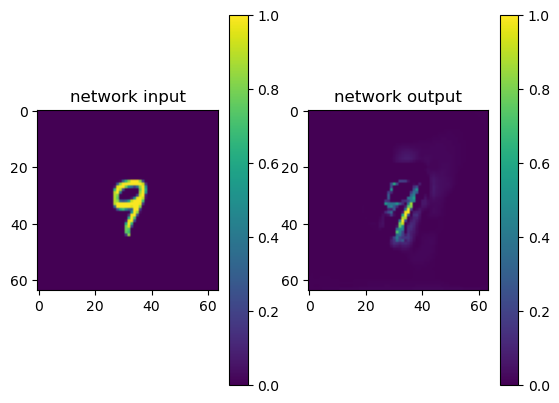

In [51]:
# pass a batch of images through the network
img = next(iter(dataloader_train))[0][1]

xhat = net(img.to(device).unsqueeze(0))
print(xhat.shape)

plt.subplot(121)
plt.imshow(img[0].cpu().squeeze())
plt.colorbar()
plt.title('network input')

plt.subplot(122)
plt.imshow(xhat[0].detach().cpu().squeeze())
plt.colorbar()
plt.title('network output')
plt.show()

# Train the network

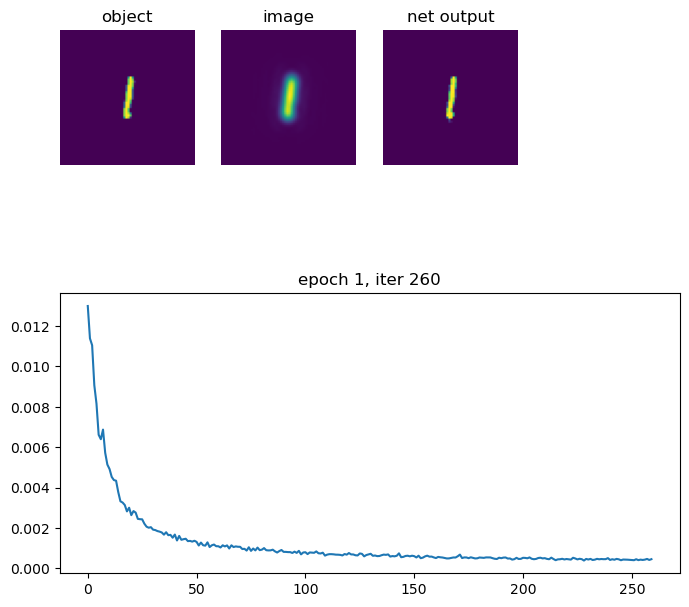

KeyboardInterrupt: 

In [52]:
# supervised training
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
forwardModel.OTF = forwardModel.OTF.to(device)


loss_train_vec = []

# training loop
n_epochs = 10
i_iter = 0
for epoch in range(1,n_epochs):
    for data, label in dataloader_train:
        x = data.to(device)
        y = forwardModel(x)
        xhat = net(x)
    
        # compare recovered image with ground truth
        loss = loss_fn(xhat,x)
        optimizer.zero_grad()
    
        loss.backward()
        optimizer.step()
    
        loss_train_vec += [loss.item()]
        i_iter += 1
    
        # plot training/validation loss curves
        if i_iter % 20 == 0:
            clear_output(wait=True)
            plt.figure(figsize=[8,8])
            plt.subplot(241)
            plt.imshow(x[0].cpu().squeeze())
            plt.axis('off')
            plt.title('object')
            plt.subplot(242)
            plt.imshow(y[0].cpu().squeeze())
            plt.axis('off')
            plt.title('image')
            plt.subplot(243)
            plt.imshow(xhat[0].detach().cpu().squeeze())
            plt.axis("off")
            plt.title('net output')
            plt.subplot(212)
            plt.plot(loss_train_vec)
            plt.title(f'epoch {epoch}, iter {i_iter}')
            plt.show()
    

# Activity

In [ ]:
# your turn: change one thing above and run it again. A few ideas
# - change pupil diameter
# - change learning rate
# - try L1 loss instead of MSE loss
# - change neural network architecture
# - add validation tracking to the training loop
# - test on out-of-distribution images
# - add noise to simulated image
# - compare with Wiener deconvolution


# Extras

## Physics-informed (unsupervised) learning

In [23]:
class GradientMagnitude(nn.Module):
    def __init__(self,dev):
        super().__init__()
        self.sobel_x = torch.tensor([[1.,0.,-1.],[2.,0.,-2.],[1.,0.,1.]]).unsqueeze(0).unsqueeze(0).to(dev)
        self.sobel_y = torch.tensor([[1.,2.,1.],[0.,0.,0.],[-1.,-2.,-1.]]).unsqueeze(0).unsqueeze(0).to(dev)

    def forward(self, x):
        # calculate summed magnitude of the gradients of an image
        grad_x = F.conv2d(x,self.sobel_x)
        grad_y = F.conv2d(x,self.sobel_y)
    
        absgrad = torch.abs(grad_x)**2 + torch.abs(grad_y)**2
        return torch.mean(absgrad)

class LaplacianVariance(nn.Module):
    # alternative loss function for sharpness
    # rough draft only -- UNTESTED
    def __init__(self,dev):
        super().__init__()
        self.kernel = torch.tensor([[0.25,0.5,0.25],[0.5,-3.,0.5],[0.25,0.5,0.25]]).unsqueeze(0).unsqueeze(0).to(dev)

    def forward(self, x):
        # calculate summed magnitude of the gradients of an image
        L = F.conv2d(x,self.kernel)
        v = torch.var(L)
        
        return v        

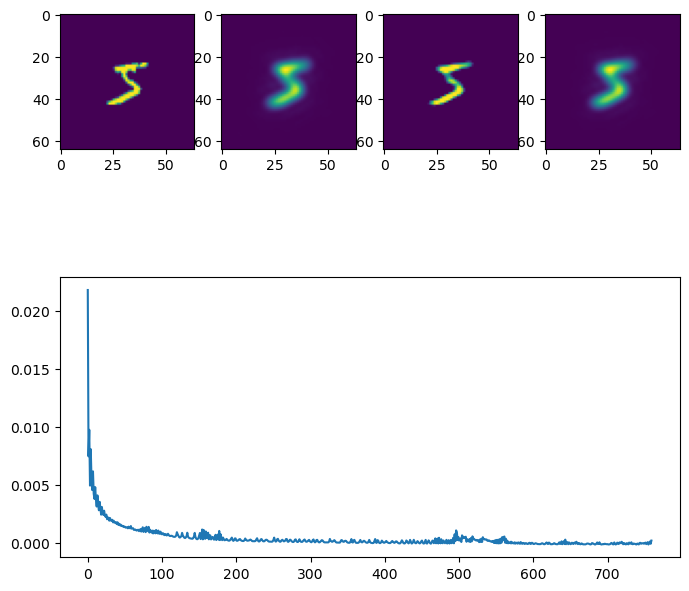

In [ ]:
# unsupervised training
# sometimes gets stuck producing blank output, may need to restart a few times
# to obtain reasonable results
net = UNet().to(device)

# results are extremely sensitive to lr and lambda_gradmag
lr = 0.001
lambda_gradmag = 0.001

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',patience=10,cooldown=10)
loss_fn = nn.L1Loss()
loss_fn_gradmag = GradientMagnitude(device)
forwardModel.OTF = forwardModel.OTF.to(device)

loss_train_vec = []

ind = 0
x = dataset_train[ind][0].to(device)
y = forwardModel(x)

# training loop
n_epochs = 1000
for epoch in range(1,n_epochs):
    xhat = net(y.unsqueeze(0))

    # pass output through imaging system
    yhat = forwardModel(xhat)
    

    # compare recovered image with measurement
    loss = loss_fn(yhat,y) - lambda_gradmag*loss_fn_gradmag(xhat)
    #loss = loss_fn(yhat,y)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    #scheduler.step(loss)

    loss_train_vec += [loss.item()]
    
    # plot training/validation loss curves
    clear_output(wait=True)
    plt.figure(figsize=[8,8])
    plt.subplot(241)
    plt.imshow(x.cpu().squeeze())
    plt.subplot(242)
    plt.imshow(y.cpu().squeeze())
    plt.subplot(243)
    plt.imshow(xhat.detach().cpu().squeeze())
    plt.subplot(244)
    plt.imshow(yhat.detach().cpu().squeeze())
    plt.subplot(212)
    plt.plot(loss_train_vec)
    plt.show()
    

In [ ]:
ind = randint(0,(len(dataset_train)-1))

x = dataset_train[ind][0].to(device)
y = forwardModel(x)
with torch.no_grad():
    xhat = net(y.unsqueeze(0))

plt.subplot(131)
plt.imshow(y.cpu().squeeze())
plt.title('blurry')
plt.subplot(132)
plt.imshow(xhat.cpu().squeeze())
plt.title('estimate')
plt.subplot(133)
plt.imshow(x.cpu().squeeze())
plt.title('ground truth')
plt.show()